In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader



In [ ]:

# CIFAR-10 dataset with normalization and transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 training data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=0)

Files already downloaded and verified


In [ ]:

# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False),
            nn.Tanh()

        )

    def forward(self, z):
        z = z.view(-1, 100, 1, 1)
        return self.model(z)
# Critic (Discriminator)
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.model = nn.Sequential(

            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 1, 4, 1, 0, bias=False),

        )
    def forward(self, x):
        return self.model(x)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move models to device
NetG = Generator().to(device)
NetC = Critic().to(device)

In [ ]:

# Wasserstein Loss Function
def wasserstein_loss(y_real, y_fake):
    return torch.mean(y_fake) - torch.mean(y_real)

# Gradient Penalty function
def gradient_penalty(critic, real_data, fake_data):
    # Ensure tensors are on the same device
    alpha = torch.rand(real_data.size(0), 1, 1, 1).to(real_data.device)
    interpolates = alpha * real_data + (1 - alpha) * fake_data

    interpolates.requires_grad_(True)
    critic_interpolates = critic(interpolates)

    gradients = torch.autograd.grad(
        outputs=critic_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(critic_interpolates),
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]

    gradient_norm = gradients.view(gradients.size(0), -1).norm(2, dim=1)
    penalty = torch.mean((gradient_norm - 1) ** 2)

    return penalty

In [ ]:
# Function to compute gradient norms per layer
def gradient_norms_per_layer(model):
    layer_norms = []
    for param in model.parameters():
        if param.grad is not None:
            layer_norms.append(param.grad.norm().item())
    return layer_norms

# Train WGAN
def train_wgan(generator, critic, dataloader, num_epochs, device):
    # Learning rates and optimizers
    lr = 0.00005
    optimizer_G = optim.RMSprop(generator.parameters(), lr=lr)
    optimizer_D = optim.RMSprop(critic.parameters(), lr=lr)

    # Lists to store training statistics
    generator_losses = []
    critic_losses = []
    gradient_norms_generator = []
    gradient_norms_critic = []

    # Training loop
    for epoch in range(num_epochs):
        epoch_generator_loss = 0
        epoch_critic_loss = 0
        generator_norms = []
        critic_norms = []

        iterations = 0
        for i, (data, _) in enumerate(dataloader):
            optimizer_D.zero_grad()
            real_data = data.to(device)
            z = torch.randn(real_data.size(0), 100).to(device)
            fake_data = generator(z)

            # Critic update with gradient penalty
            critic_loss = wasserstein_loss(critic(real_data), critic(fake_data)) + gradient_penalty(critic, real_data, fake_data)
            critic_loss.backward()
            critic_norms.append(gradient_norms_per_layer(critic))
            optimizer_D.step()

            epoch_critic_loss += critic_loss.item()
            iterations += 1

            # Generator update every 5 iterations
            if iterations % 10 == 0:
                optimizer_G.zero_grad()
                z = torch.randn(real_data.size(0), 100).to(device)  # Refresh noise
                fake_data = generator(z)
                generator_loss = -torch.mean(critic(fake_data))
                generator_loss.backward()
                generator_norms.append(gradient_norms_per_layer(generator))
                optimizer_G.step()

                epoch_generator_loss += generator_loss.item()

        # Store the average losses and gradient norms
        generator_losses.append(epoch_generator_loss / (iterations/10))
        critic_losses.append(epoch_critic_loss / iterations)
        gradient_norms_generator.append(generator_norms)
        gradient_norms_critic.append(critic_norms)

        # Print epoch progress
        print(f"Epoch {epoch + 1}/{num_epochs}, Generator Loss: {generator_losses[-1]:.4f}, Critic Loss: {critic_losses[-1]:.4f}")

    return generator_losses, critic_losses, gradient_norms_critic, gradient_norms_generator

In [ ]:
generator_losses, critic_losses, gradient_norms_critic, gradient_norms_generator = train_wgan(NetG, NetC, trainloader, num_epochs=20,device = device)

Epoch 1/20, Generator Loss: 1620.7554, Critic Loss: -1.0147
Epoch 2/20, Generator Loss: 1625.0973, Critic Loss: -0.9123
Epoch 3/20, Generator Loss: 1623.8818, Critic Loss: -1.1602
Epoch 4/20, Generator Loss: 1621.2461, Critic Loss: -1.3838
Epoch 5/20, Generator Loss: 1618.9183, Critic Loss: -1.6066
Epoch 6/20, Generator Loss: 1614.5275, Critic Loss: -1.7732
Epoch 7/20, Generator Loss: 1610.2433, Critic Loss: -1.9023
Epoch 8/20, Generator Loss: 1605.8071, Critic Loss: -1.9783
Epoch 9/20, Generator Loss: 1601.0355, Critic Loss: -2.0144
Epoch 10/20, Generator Loss: 1597.4149, Critic Loss: -2.0938
Epoch 11/20, Generator Loss: 1593.0650, Critic Loss: -2.1860
Epoch 12/20, Generator Loss: 1589.7736, Critic Loss: -2.2098
Epoch 13/20, Generator Loss: 1586.2478, Critic Loss: -2.2783
Epoch 14/20, Generator Loss: 1583.0802, Critic Loss: -2.3094
Epoch 15/20, Generator Loss: 1579.2569, Critic Loss: -2.3858
Epoch 16/20, Generator Loss: 1575.8527, Critic Loss: -2.3639
Epoch 17/20, Generator Loss: 1572

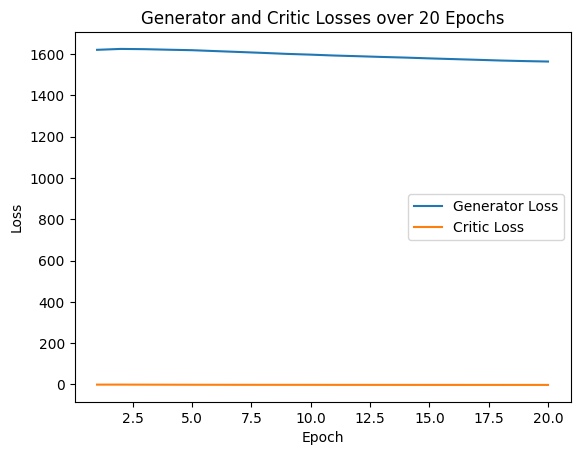

In [ ]:

import matplotlib.pyplot as plt
epochs = list(range(1, 21))

plt.plot(epochs, generator_losses, label='Generator Loss')
plt.plot(epochs, critic_losses, label='Critic Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator and Critic Losses over 20 Epochs')
plt.legend()
plt.show()


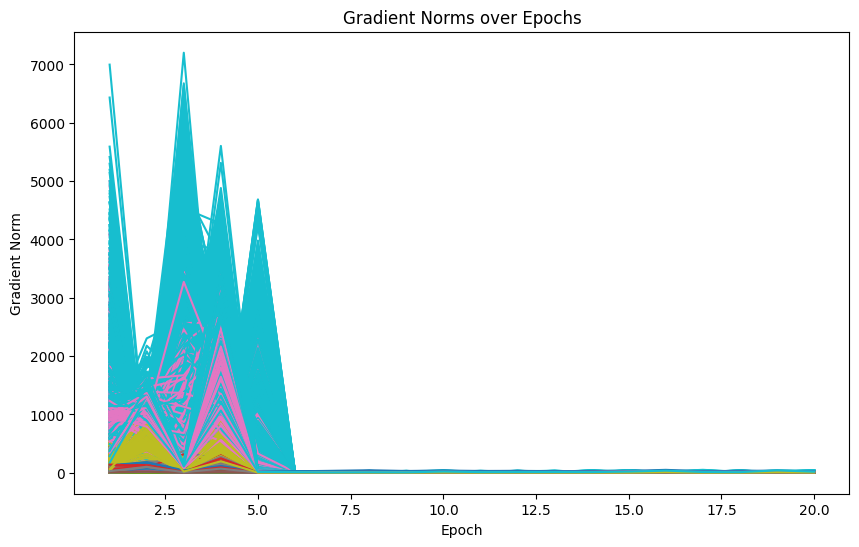

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
for i in range(len(gradient_norms_generator[0])):
    norms = [gradient_norms_generator[j][i] for j in range(len(gradient_norms_generator))]
    plt.plot(epochs, norms, label=f'Parameter {i+1}')

plt.xlabel('Epoch')
plt.ylabel('Gradient Norm')
plt.title('Gradient Norms over Epochs')
plt.show()




In [ ]:
import torch
import torchvision.utils as vutils
import matplotlib.pyplot as plt

# Function to generate and display images
def generate_images(generator, num_images=24, noise_dim=100, grid_size=(8, 8)):
    # Create random noise for image generation
    noise = torch.randn(num_images, noise_dim).to(generator.model[0].weight.device)

    # Generate images from the noise
    with torch.no_grad():  # No gradients needed during inference
        generated_images = generator(noise)

    # Create a grid of images for visualization
    image_grid = vutils.make_grid(generated_images, nrow=grid_size[0], padding=2, normalize=True)
    image_grid = image_grid.cpu()

    # Display the image grid
    plt.imshow(image_grid.permute(1, 2, 0))  # Convert to HxWxC format
    plt.axis('off')  # Hide axes
    plt.show()  # Display the generated images


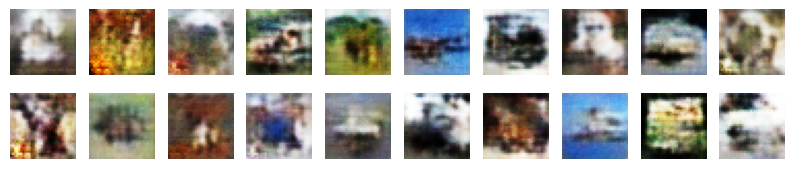

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch



n_classes = 10
n_examples = 2
fixed_noise = torch.randn(n_classes * n_examples, 100, 1, 1, device=device) # noise dimension 100
labels = torch.arange(n_classes).repeat(n_examples)
with torch.no_grad():
    NetG.eval()
    fake_images = NetG(fixed_noise).detach().cpu()

import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10, 2 ))
for i in range(n_classes * n_examples):
    img = fake_images[i] / 2 + 0.5
    npimg = img.numpy()
    plt.subplot(2, 10, i + 1)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

#show 20 pictures
plt.show()

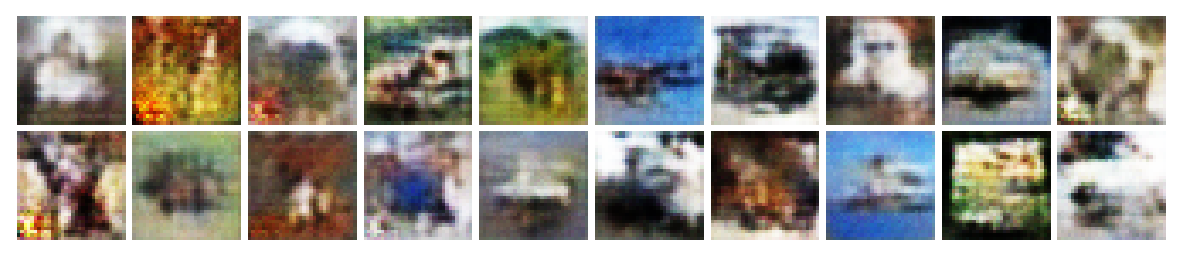

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

# Function to show images
def show_images(images, num_images, nrow=10, names=None, name_scale=1):
    plt.figure(figsize=(15 / 10 * nrow, 15))
    images = make_grid(images.cpu()[:num_images], nrow=nrow, padding=2, pad_value=1)
    images =  np.clip(images, 0, 1)
    npimg = images.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    single_img_height = npimg.shape[1] // (num_images // nrow) * name_scale
    if names is not None:
        for i, name in enumerate(names):
            if i >= num_images:
                break  # Break if there are more names than images
            row = i // nrow - 1
            col = i % nrow
            plt.text(col * single_img_height + single_img_height / 2, (row + 1) * single_img_height - single_img_height * 0.14,
                     name, ha='center', va='top', fontsize=12, color='black',
                     bbox=dict(facecolor='white', alpha=0.5, edgecolor='white', boxstyle='round,pad=0.1'))
    plt.show()

show_images(fake_images/ 2 + 0.5, 20)

In [ ]:
import torch
import torch.nn.functional as F
from torchvision.models import inception_v3
from torchvision.transforms import functional as TF
import numpy as np

def inception_score(images, cuda=True, batch_size=32, resize=False, splits=10):
    """计算 Inception Score.
    参数:
    - images: PyTorch tensor, 大小 [N, 3, H, W]
    - cuda: 是否使用 GPU
    - batch_size: 处理图片的批次大小
    - resize: 是否调整图片为 (299, 299)
    - splits: 计算分数时数据集分割的数量
    """
    N = len(images)
    assert batch_size > 0
    assert N > batch_size

    # 加载 Inception 模型
    inception_model = inception_v3(pretrained=True, transform_input=False)
    inception_model.eval()
    if cuda:
        inception_model.cuda()

    def get_pred(x):
        if resize:
            x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)
        with torch.no_grad():
            x = inception_model(x)
        return F.softmax(x, dim=1).data.cpu().numpy()

    # 计算预测和边缘分布
    preds = np.zeros((N, 1000))

    for i in range(0, N, batch_size):
        batch = images[i:i + batch_size]
        if cuda:
            batch = batch.cuda()
        batch_pred = get_pred(batch)
        preds[i:i + batch_size] = batch_pred

    # 分割数据，计算 Inception Score
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k + 1) * (N // splits), :]
        p_y = np.expand_dims(np.mean(part, axis=0), 0)
        kl_div = part * (np.log(part + 1e-10) - np.log(p_y + 1e-10))
        kl_div = np.mean(np.sum(kl_div, axis=1))
        split_scores.append(np.exp(kl_div))
    return np.mean(split_scores), np.std(split_scores)

In [ ]:
fake_images = torch.randn(100, 3, 299, 299)
if torch.cuda.is_available():
    fake_images = fake_images.cuda()
score = inception_score(fake_images, cuda=True, resize=True, batch_size=4)
print(score)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 80.6MB/s] 


(1.049013282578772, 0.008896804067738035)


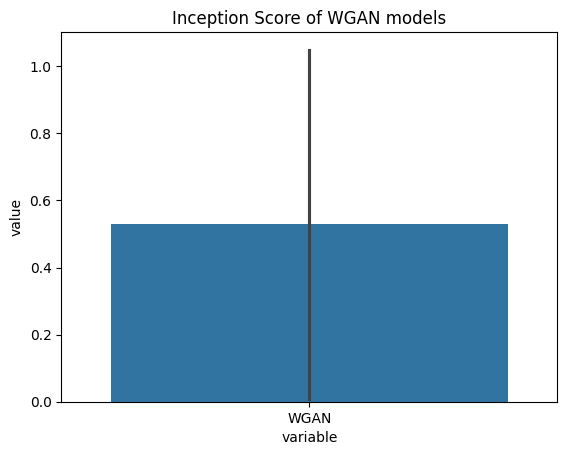

In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
# Create a DataFrame
df = pd.DataFrame({'WGAN': score})
# Melt the DataFrame to long-format
df_long = pd.melt(df, value_vars=['WGAN'])
# Create a bar plot
sns.barplot(x='variable', y='value', data=df_long)
# Set the title
# Optional: Add a title
plt.title('Inception Score of WGAN models')

# Show the plot
plt.show()

In [ ]:
torch.save(NetG.state_dict(), 'wgan_netGr.pth')
torch.save(NetC.state_dict(), 'wgan_netDr.pth')

In [ ]:
NetG.load_state_dict(torch.load('wgan_netGr.pth'))
NetC.load_state_dict(torch.load('wgan_netDr.pth'))
# Make sure to call eval() if you're in inference mode
NetG.eval()
NetC.eval()

In [ ]:
def rgb_to_grayscale_numpy(image):
	"""
	Convert an RGB image to a grayscale image using the luminosity method.
	Parameters:
		image (numpy.ndarray): The RGB image in CHW format.
	Returns:
		numpy.ndarray: The grayscale image in 1HW format (1 channel, Height, Width).
	"""
	if image.shape[0] == 3:  # Check if the input image has 3 channels (RGB)
		image = image.transpose(1, 2, 0)  # Convert to HWC format for easier processing
	# Apply the luminosity method to calculate grayscale values
	grayscale = 0.2989 * image[:, :, 0] + 0.5870 * image[:, :, 1] + 0.1140 * image[:, :, 2]
	return grayscale[np.newaxis, :, :]  # Add channel dimension back for consistency


def calculate_ssim(image1, image2):
	"""
    Calculate the Structural Similarity Index Measure (SSIM) between two images.
    Parameters:
        image1, image2 (numpy.ndarray or torch.Tensor): The input images.
    Returns:
        float: The SSIM index between the two input images.
    """
	# Convert PyTorch tensors to numpy arrays if necessary
	if torch.is_tensor(image1):
		image1 = image1.cpu().numpy()  # CHW to HWC
	if torch.is_tensor(image2):
		image2 = image2.cpu().numpy()  # CHW to HWC
	# Convert images to grayscale
	image1 = rgb_to_grayscale_numpy(image1)[0]
	image2 = rgb_to_grayscale_numpy(image2)[0]
	# Normalize images to ensure they are compared on the same scale
	image1 = (image1 - image1.min()) / (image1.max() - image1.min())
	image2 = (image2 - image2.min()) / (image2.max() - image2.min())
	# Calculate and return the SSIM
	ssim_value = ssim(image1, image2, multichannel=False, data_range=1)
	return ssim_value

In [ ]:
from skimage.metrics import structural_similarity as ssim
num_images_acc = 1000  # number of images
fake_noise_1000 = torch.randn(num_images_acc, 100, 1, 1, device=device)
fake_noise_1000_1 = torch.randn(num_images_acc, 100, 1, 1, device=device)
fake_images_1000_1 = NetG(fake_noise_1000).detach().cpu()
fake_images_1000_2 = NetG(fake_noise_1000_1).detach().cpu()
ssim_scores = []
for gen_img, gen_img2 in zip(fake_images_1000_1, fake_images_1000_2):  # 2 packs pairwise
	current_ssim = calculate_ssim(gen_img, gen_img2)
	ssim_scores.append(current_ssim)

average_ssim_ACGAN = np.mean(ssim_scores)
print(f"Average SSIM (AC-GAN): {average_ssim_ACGAN}")

In [ ]:
print(NetC)

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

model = models.resnet50(pretrained=True).to(device)
feature_extractor = nn.Sequential(*list(model.children())[:-1])  # Removing the final layer
feature_extractor.eval()

In [ ]:
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


def get_features(image, feature_extractor):
	""" Convert image to tensor, normalize, and pass through the model """
	image = normalize(image).unsqueeze(0).to(device)  # Add batch dimension
	with torch.no_grad():
		features = feature_extractor(image)
	return features.flatten()


def cosine_similarity(feat1, feat2):
	""" Compute the cosine similarity between two feature vectors """
	return torch.nn.functional.cosine_similarity(feat1, feat2, dim=0)


def cosine_similarities(features1, features2):
	num_images = len(features1)
	similarities = []
	for i in range(num_images):
		sim = cosine_similarity(features1[i].cpu(), features2[i].cpu())
		similarities.append(sim)
	return similarities


features1 = [get_features(image, feature_extractor) for image in fake_images_1000_1]
features2 = [get_features(image, feature_extractor) for image in fake_images_1000_2]
similarities = cosine_similarities(features1, features2)
average_cosine_Wgan = np.mean(similarities)
print(f"Average Cosine Similarity (W-GAN): {average_cosine_Wgan}")

In [ ]:
n_bins = 50  # You can change the number of bins based on how detailed you want the histogram to be
plt.figure(figsize=(10, 5))
plt.hist(similarities, bins=n_bins, alpha=0.75, color='blue')
plt.title('Histogram of Cosine Similarities WGAN')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')

plt.show()